In [1]:
import scvelo as scv
import scanpy as sc
import scFates as scf
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import palantir
from cuml import UMAP
%matplotlib inline
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo',figsize=(5,5),dpi_save=600)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

In [2]:
import pandas as pd
auc=pd.read_csv("scenic/output/auc_mtx_mm10.csv",index_col=0)

In [3]:
def subset(adata,root,leaves):
    
    path=scf.tools.getpath(adata,root_milestone=root,milestones=leaves)
    path=path[~path.index.duplicated(keep='first')]
    import numpy as np

    colkeep=list(map(lambda m: adata.uns["milestones_colors"][np.argwhere(adata.obs.milestones.cat.categories==m)[0][0]],
         path.milestones.unique()))
    
    adata=adata[path.index,]    
    del adata.uns
    adata.obs["old_milestones"] = adata.obs["milestones"]
    adata.obs.old_milestones=adata.obs.old_milestones.cat.reorder_categories(path.milestones.unique())
    adata.uns["old_milestones_colors"] = colkeep
    
    return adata

In [5]:
adata=sc.read("adata_tree_fpm.h5ad")

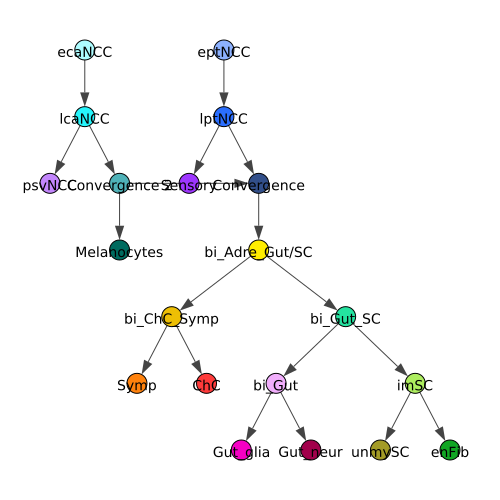

In [6]:
scf.pl.milestones(adata)

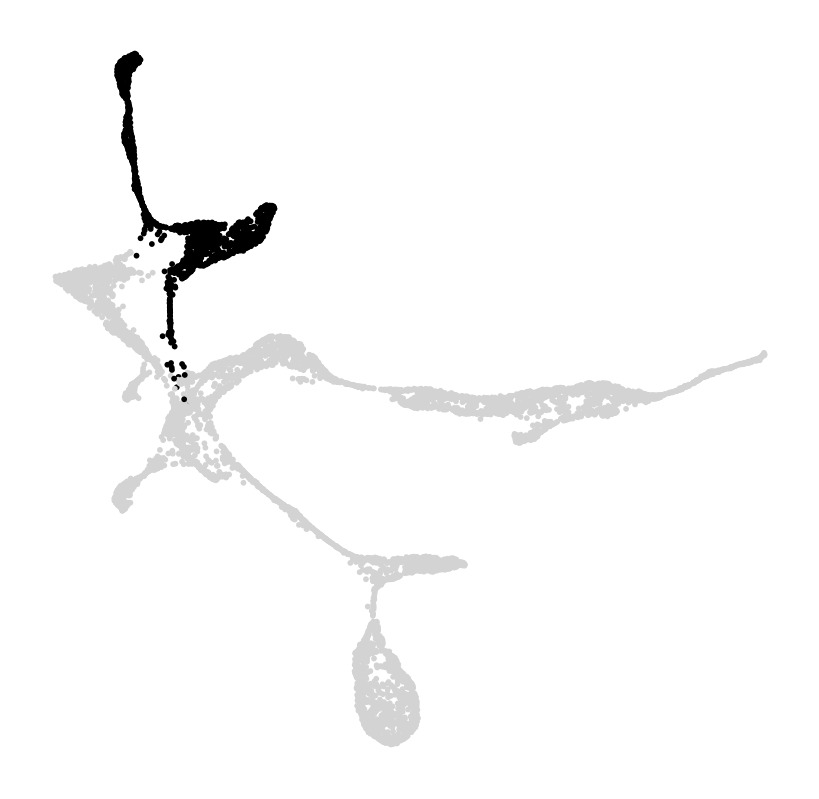

In [7]:
path=scf.tools.getpath(adata,"eptNCC",["Sensory","Convergence"])
path=path[~path.index.duplicated(keep='first')]
adata.obs["sel"]=adata.obs_names.isin(path.index)
adata.obs["sel"]=adata.obs["sel"].astype("category")
sc.pl.umap(adata,color="sel",palette=["lightgrey","black"],frameon=False,legend_loc="none",title="",
           save="-Bif_Sensory.png")

In [8]:
adata=subset(adata,"eptNCC",["Sensory","Convergence"])

In [9]:
scf.tl.tree(adata,Nodes=500,ppt_err_cut=0.01,
            use_rep="diffusion",ppt_sigma = 0.05,ppt_lambda=100,
            method="ppt",device="gpu",seed=1)

inferring a principal tree --> parameters used 
    500 principal points, sigma = 0.05, lambda = 100, metric = euclidean
    fitting:  26%|██▌       | 13/50 [00:02<00:07,  4.85it/s]
    converged
    finished (0:00:06) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['R'] soft assignment of cells to principal point in representation space.
    .uns['graph']['F'] coordinates of principal points in representation space.


    graph cleaned --> removed 85 principal points


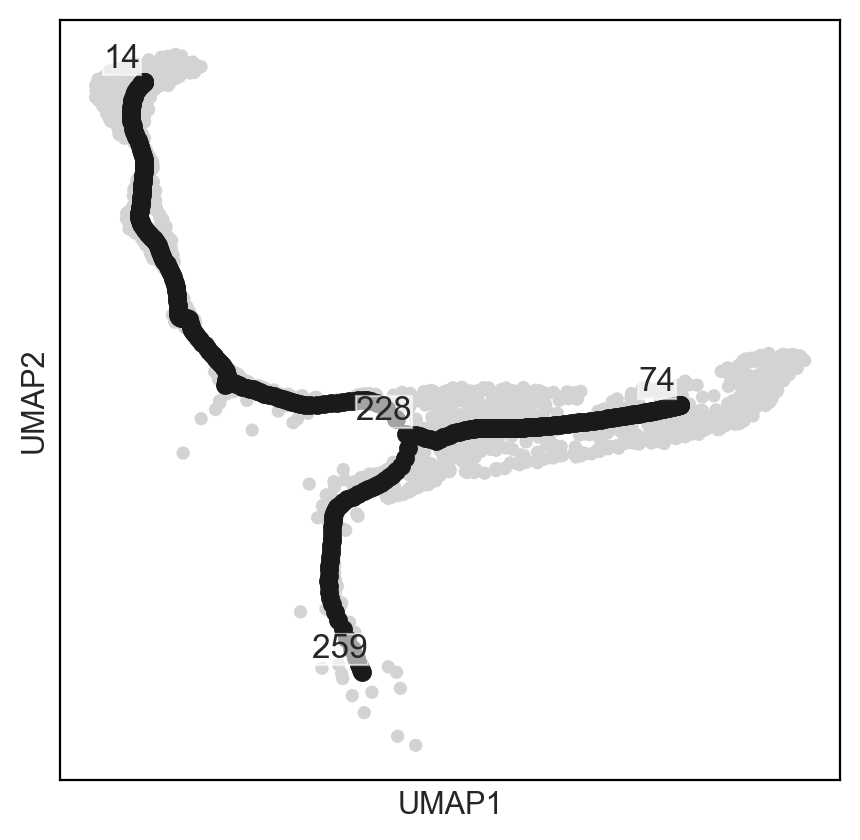

In [11]:
scf.tl.cleanup(adata,minbranchlength=50)
scf.pl.graph(adata)

In [10]:
scf.tl.root(adata,74)

root selected --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [11]:
scf.tl.pseudotime(adata,n_jobs=40)

projecting cells onto the principal graph
    finished (0:00:01) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


In [12]:
adata.uns["graph"]["milestones"]

{'14': 14, '228': 228, '259': 259, '74': 74}

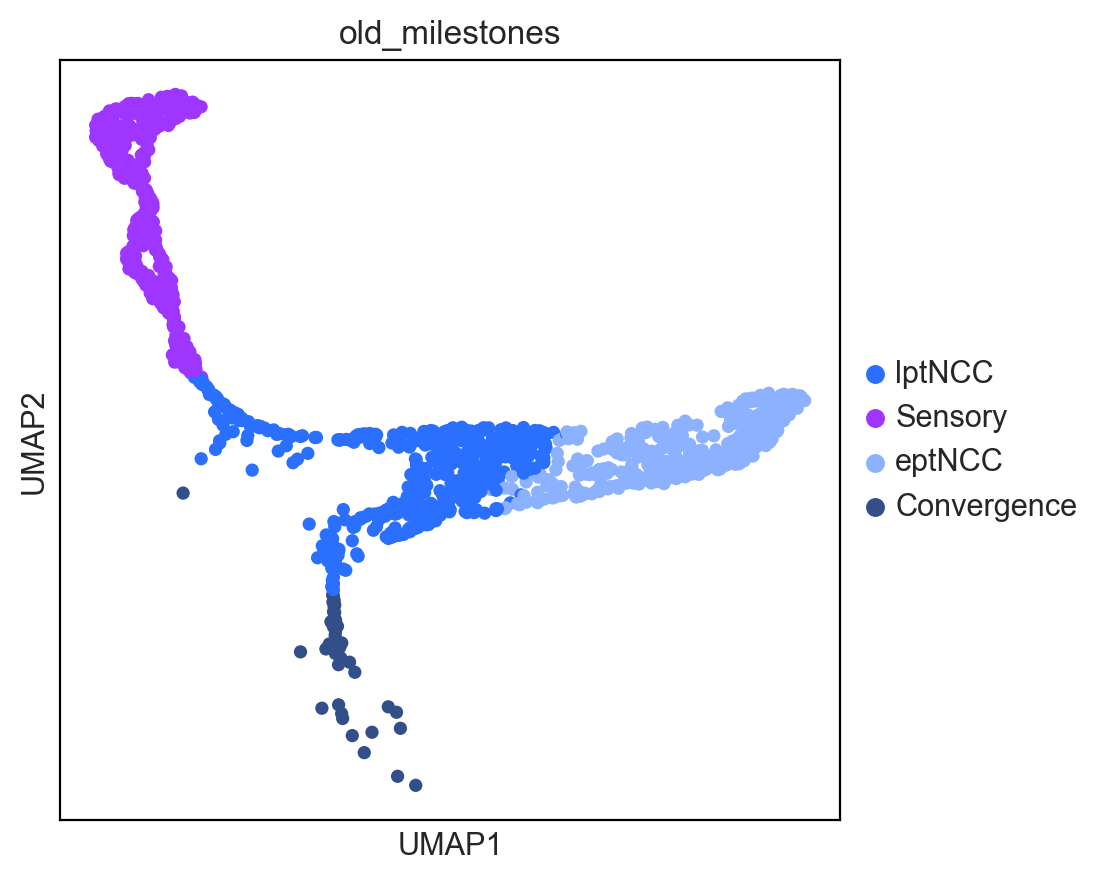

In [13]:
sc.pl.umap(adata,color="old_milestones")

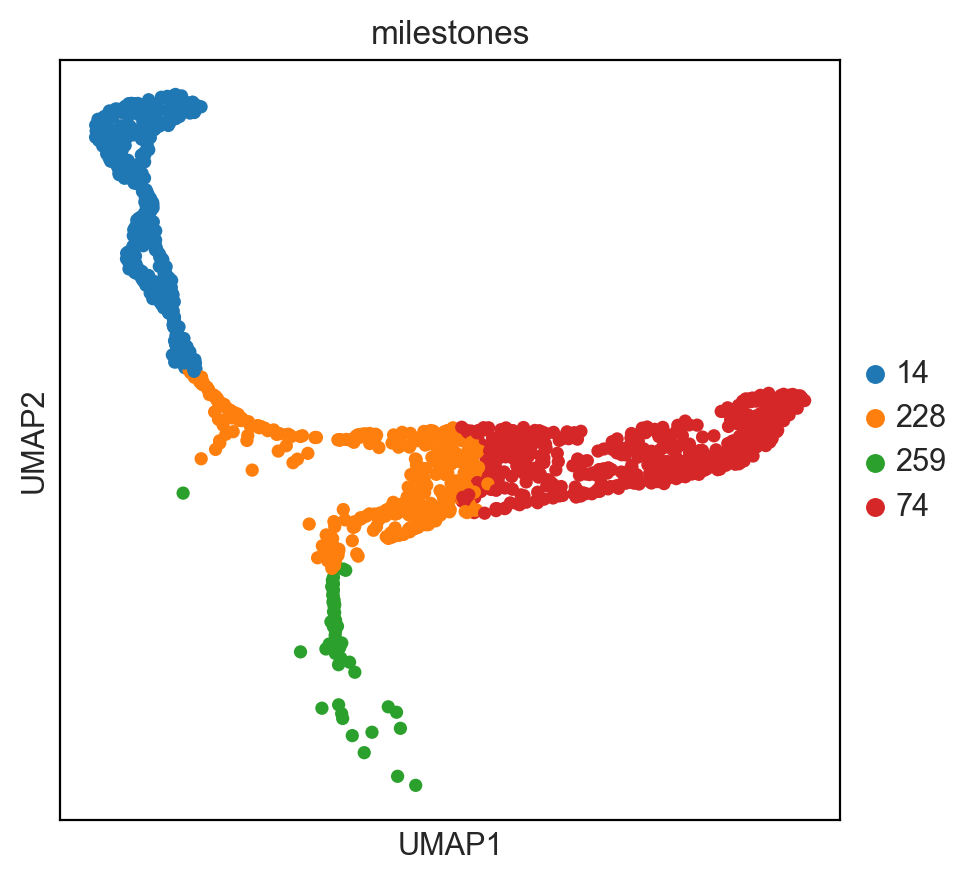

In [14]:
sc.pl.umap(adata,color="milestones")

In [15]:
mil=["Sensory","lptNCC","Convergence","eptNCC"]
scf.tl.rename_milestones(adata,mil)
adata.uns["graph"]["milestones"]

{'Sensory': 14, 'lptNCC': 228, 'Convergence': 259, 'eptNCC': 74}

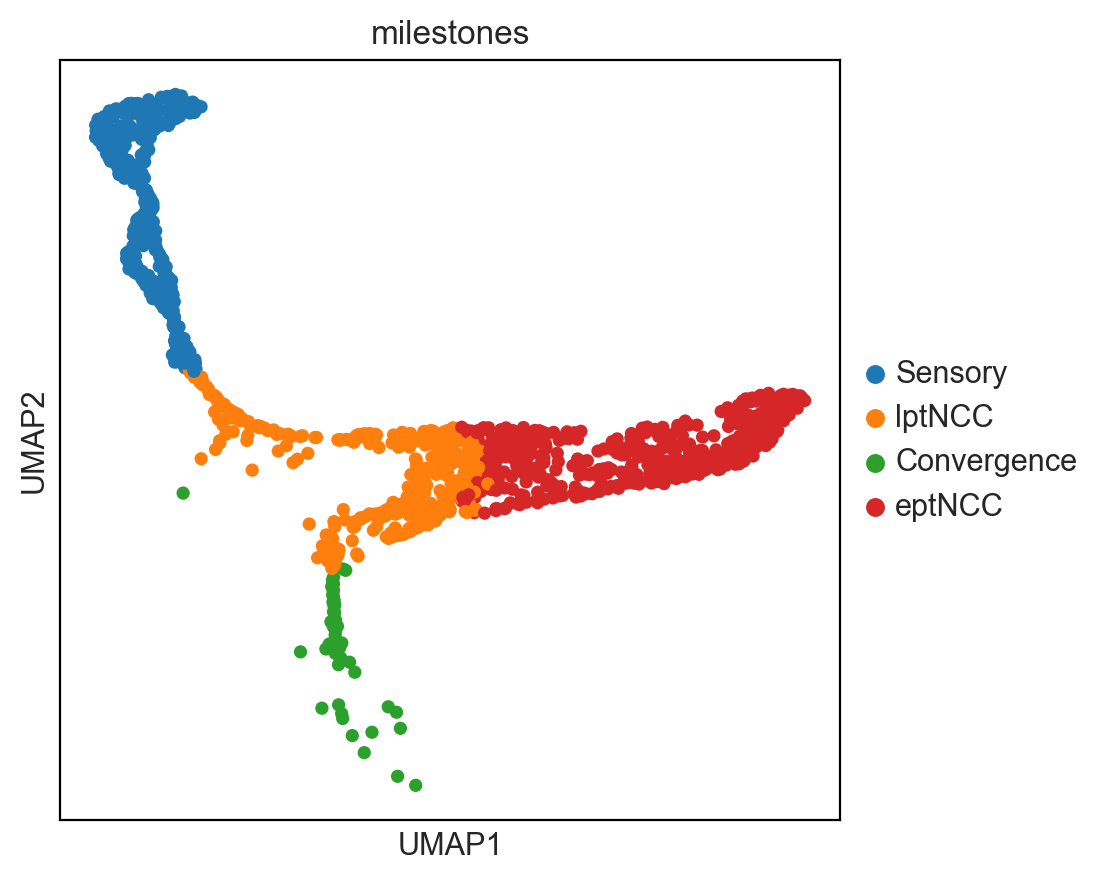

In [16]:
sc.pl.umap(adata,color="milestones")

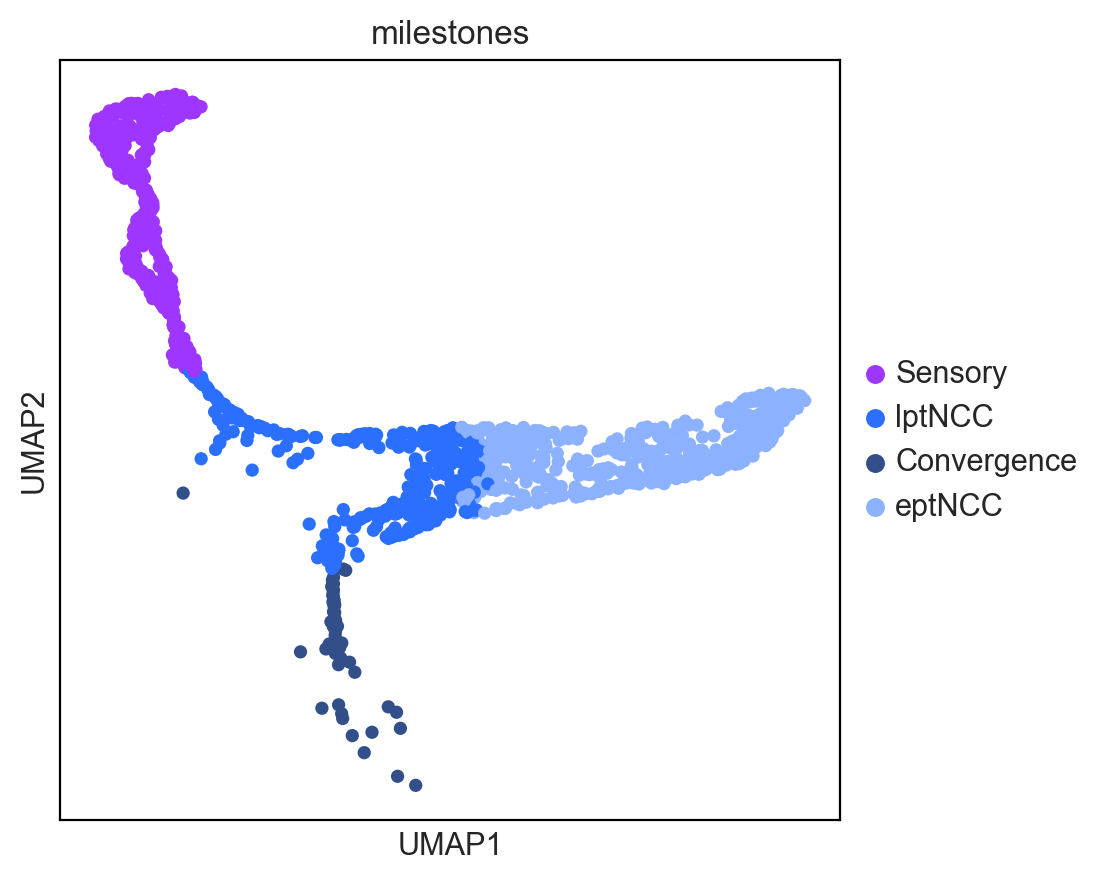

In [17]:
dct=dict(zip(adata.obs.old_milestones.cat.categories,adata.uns["old_milestones_colors"]))
adata.uns["milestones_colors"]=[dct[idx] for idx in adata.obs.milestones.cat.categories]
sc.pl.umap(adata,color="milestones")

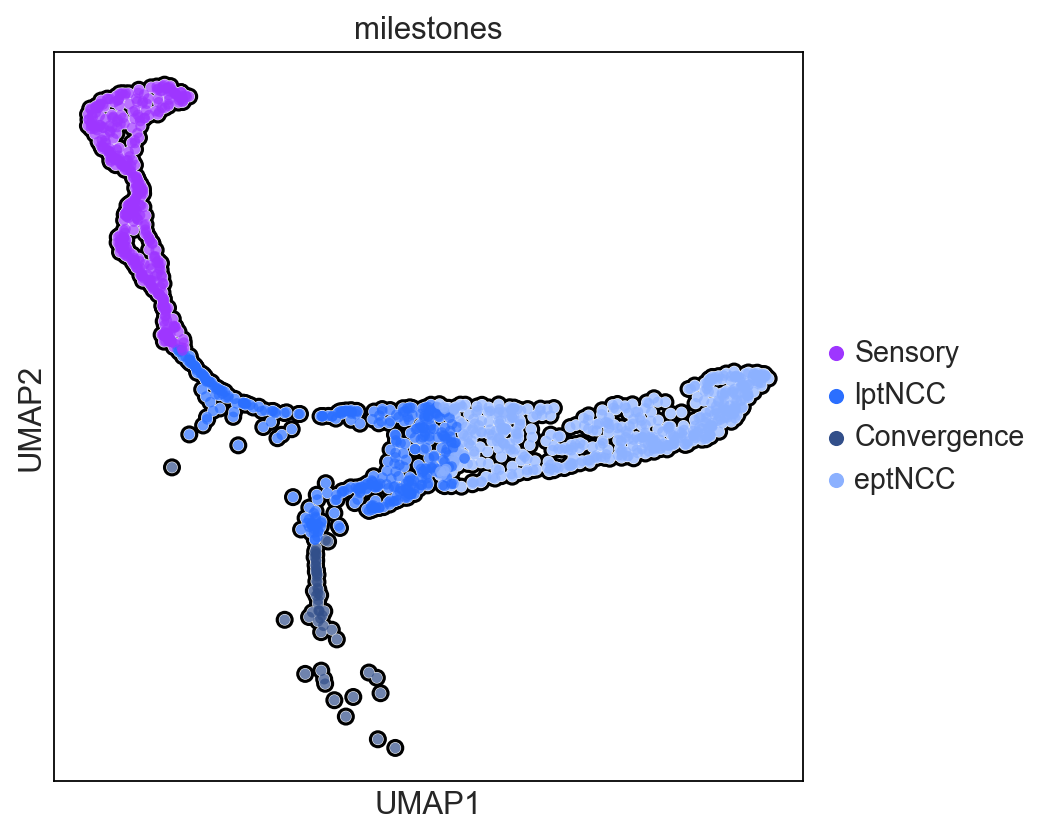

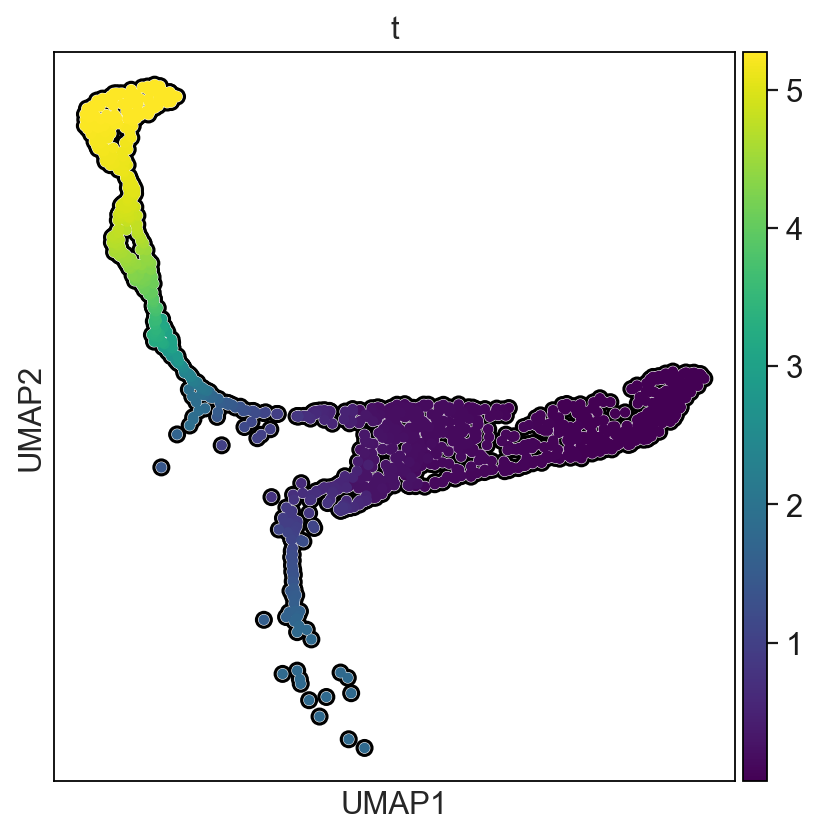

In [23]:
sc.set_figure_params(figsize=(6,6),dpi_save=600)
sc.pl.umap(adata,color="milestones",add_outline=True,save="milestones-Sensory.svg")
sc.pl.umap(adata,color="t",add_outline=True,color_map="viridis",alpha=1,save="pseudotime-Sensory.svg")

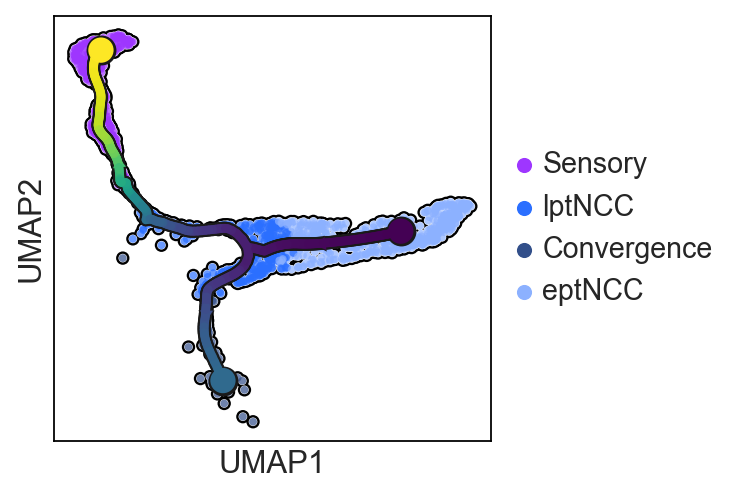

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3.5,3.5))
sc.pl.umap(adata,color="milestones",show=False,add_outline=True,ax=ax,size=50)
scf.pl.trajectory(adata,arrows=True,scale_path=.8,alpha=0,ax=ax,arrow_offset=10,
                  save="-Bif_Sensory.svg")

In [36]:
sc.pp.filter_genes(adata,min_cells=3)
scf.tl.test_association(adata,n_jobs=40,n_map=1)

test features for association with the trajectory
    single mapping : 100%|██████████| 18324/18324 [01:15<00:00, 243.18it/s]
    found 3116 significant features (0:01:16) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [37]:
root_mil="eptNCC"
miles=["Sensory","Convergence"]

In [38]:
scf.tl.test_fork(adata,root_milestone=root_mil,milestones=miles,n_jobs=20,rescale=True,n_map=1)

testing fork
    single mapping
    differential expression: 100%|██████████| 18324/18324 [01:13<00:00, 249.48it/s]
    test for upregulation for each leave vs root
    leave Convergence: 100%|██████████| 10743/10743 [00:03<00:00, 3560.04it/s]
    finished (0:01:23) --> added 
    .uns['eptNCC->Sensory<>Convergence']['fork'], DataFrame with fork test results.


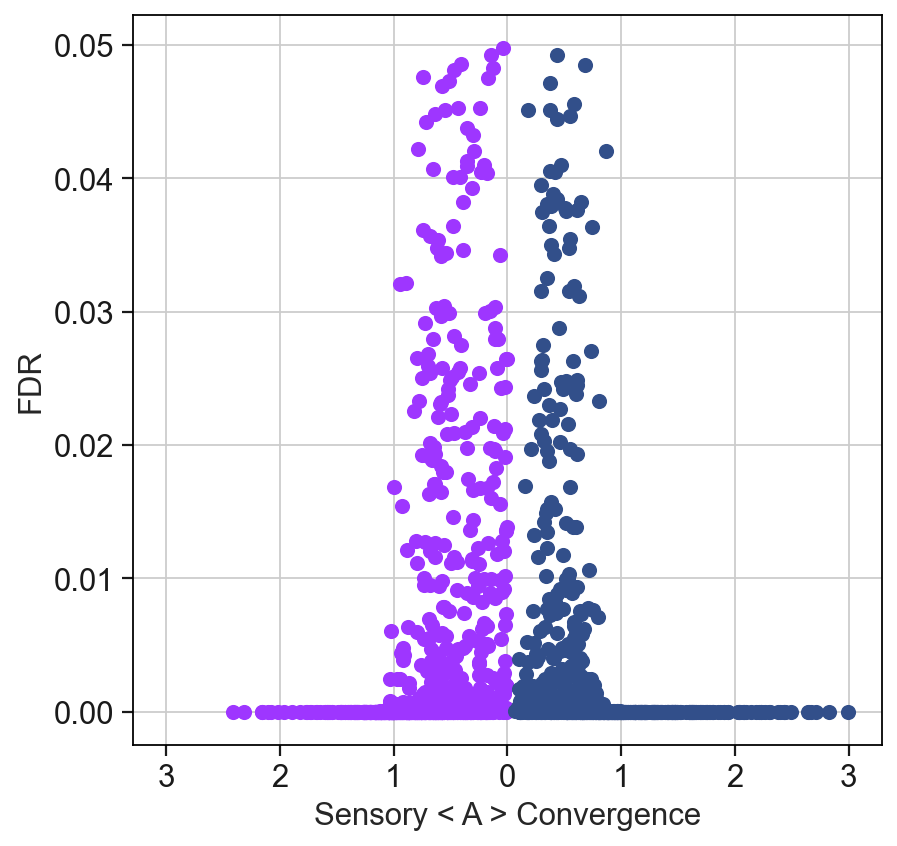

In [39]:
sc.set_figure_params(figsize=(6,6))
scf.pl.test_fork(adata,root_milestone=root_mil,milestones=miles)

In [40]:
scf.tl.branch_specific(adata,root_milestone=root_mil,milestones=miles,effect=1)

    branch specific features: Sensory: 195, Convergence: 49
    finished --> updated 
    .uns['eptNCC->Sensory<>Convergence']['fork'], DataFrame updated with additionnal 'branch' column.


In [41]:
scf.tl.activation(adata,root_milestone=root_mil,milestones=miles,n_jobs=20,
                  pseudotime_offset=0.1,deriv_cut=.2)

testing activation
    leave Convergence: 100%|██████████| 49/49 [00:00<00:00, 227.87it/s]
    threshold pseudotime is: 0.2930081416552227
    18 early and 177 late features specific to leave Sensory
    25 early and 24 late features specific to leave Convergence
    finished (0:00:03) --> updated 
    .uns['eptNCC->Sensory<>Convergence']['fork'], DataFrame updated with additionnal 'activation' and 'module' columns.


In [43]:
scf.tl.fit(adata,n_jobs=40,n_map=1)

fit features associated with the trajectory
    single mapping : 100%|██████████| 3116/3116 [00:35<00:00, 88.13it/s] 
    finished (adata subsetted to keep only fitted features!) (0:00:38) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [47]:
df=adata.uns['eptNCC->Sensory<>Convergence']['fork']

Index(['Thsd7b', 'St18', 'Slco5a1', 'Klf7', 'Nfasc', 'Tmcc2', 'Cntn2', 'Igsf9',
       'Cnst', 'Gdap1',
       ...
       'Fbxl16', 'Mtcl1', 'Myo5b', 'Zeb1', 'Epb4.1l4a', 'Synpo', 'Sptbn2',
       'Hspa12a', 'Ctsf', 'Flrt1'],
      dtype='object', length=195)

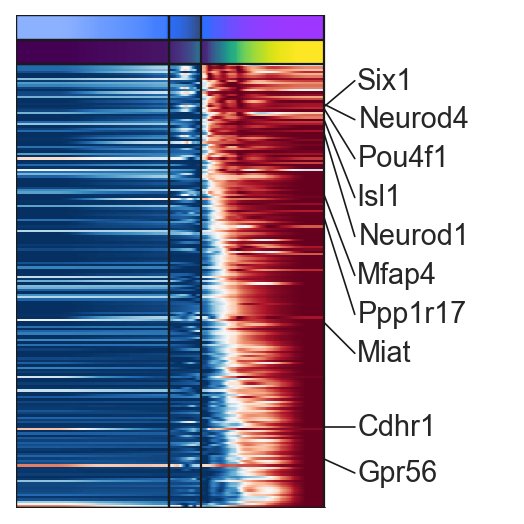

In [63]:
scf.pl.trends(adata,features=df.index[df.branch=="Sensory"],annot="milestones",
              plot_emb=False,fig_heigth=3.5,heatmap_space=.4,offset_names=.1,fontsize=13,save="Sensorybif_sensory.svg")

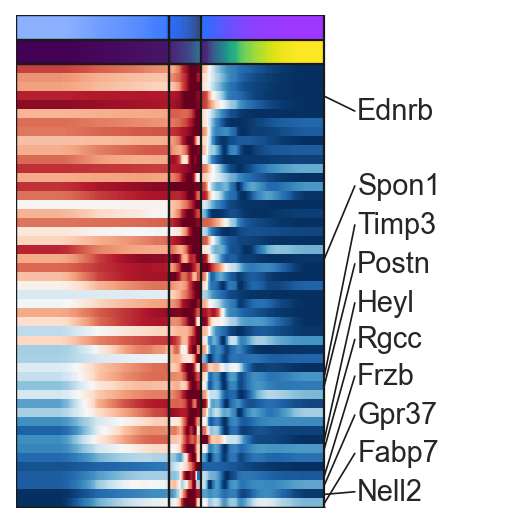

In [64]:
scf.pl.trends(adata,features=df.index[df.branch=="Convergence"],annot="milestones",
              plot_emb=False,fig_heigth=3.5,heatmap_space=.4,offset_names=.1,fontsize=13,save="Sensorybif_convergence.svg")